#Download Dataset

In [ ]:
from google.colab import files
files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d adityajn105/flickr8k

import os
import zipfile

local_zip = 'flickr8k.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

100% 1.03G/1.04G [00:04<00:00, 197MB/s]
100% 1.04G/1.04G [00:05<00:00, 221MB/s]


#Image Processing

In [ ]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob

In [ ]:
images_path = '/content/data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

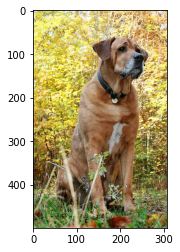

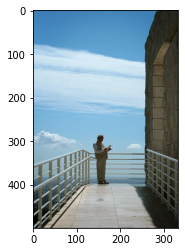

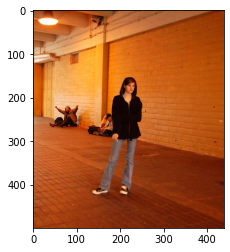

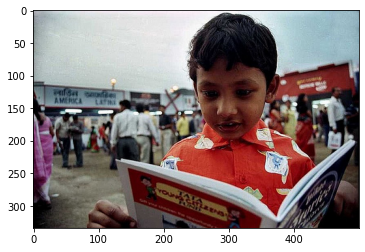

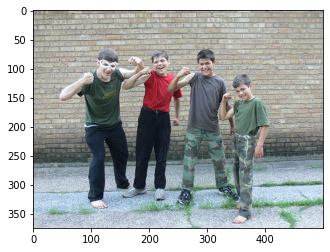

In [ ]:

import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [ ]:
from keras.applications import ResNet50

incept_model = ResNet50(include_top=True)

102973440/102967424 [==============================] - 0s 0us/step


In [ ]:
incept_model.summary()

In [ ]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

In [ ]:

images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [ ]:
len(images_features)

1500

# Text Processing

In [ ]:
caption_path = '/content/data/captions.txt'

In [ ]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [ ]:
captions

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow wi

In [ ]:
captions[10].split(',')[1]

'Two dogs on pavement moving toward each other .'

In [ ]:

captions_dict = {}
for i in captions:
    try:
        img_name = i.split(',')[0] 
        caption = i.split(',')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
                          
    except:
        print('no')
        pass


no
no


In [ ]:
captions_dict

{'1003163366_44323f5815.jpg': ['A man lays on a bench while his dog sits by him .',
  'A man lays on the bench to which a white dog is also tied .',
  'a man sleeping on a bench outside with a white and black dog sitting next to him .',
  'A shirtless man lies on a park bench with his dog .',
  'man laying on bench holding leash of dog sitting on ground'],
 '1009434119_febe49276a.jpg': ['A black and white dog is running in a grassy garden surrounded by a white fence .',
  'A black and white dog is running through the grass .',
  'A Boston terrier is running in the grass .',
  'A Boston Terrier is running on lush green grass in front of a white fence .',
  'A dog runs on the green grass near a wooden fence .'],
 '1020651753_06077ec457.jpg': ['a black and white dog jumping in the air to get a toy .',
  'A black and white dog jumps up towards a yellow toy .',
  'A dog leaps to catch a ball in a field .',
  'A white dog is trying to catch a ball in midair over a grassy field .',
  'The whi

In [ ]:

len(captions_dict)

1500

In [ ]:
def preprocessed(txt):
  modified= txt.lower()
  modified= 'startofseq ' + modified + ' endofseq'
  return modified

In [ ]:
for k,v in captions_dict.items():
  for vv in v:
    captions_dict[k][v.index(vv)]= preprocessed(vv)

In [ ]:
captions_dict

{'1003163366_44323f5815.jpg': ['startofseq a man lays on a bench while his dog sits by him . endofseq',
  'startofseq a man lays on the bench to which a white dog is also tied . endofseq',
  'startofseq a man sleeping on a bench outside with a white and black dog sitting next to him . endofseq',
  'startofseq a shirtless man lies on a park bench with his dog . endofseq',
  'startofseq man laying on bench holding leash of dog sitting on ground endofseq'],
 '1009434119_febe49276a.jpg': ['startofseq a black and white dog is running in a grassy garden surrounded by a white fence . endofseq',
  'startofseq a black and white dog is running through the grass . endofseq',
  'startofseq a boston terrier is running in the grass . endofseq',
  'startofseq a boston terrier is running on lush green grass in front of a white fence . endofseq',
  'startofseq a dog runs on the green grass near a wooden fence . endofseq'],
 '1020651753_06077ec457.jpg': ['startofseq a black and white dog jumping in the 

# **Create Vocabulary**


In [ ]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [ ]:
len(count_words)

4028

In [ ]:
count_words

{'startofseq': 12526,
 'a': 18803,
 'man': 2367,
 'lays': 9,
 'on': 3167,
 'bench': 153,
 'while': 588,
 'his': 767,
 'dog': 2154,
 'sits': 189,
 'by': 324,
 'him': 112,
 '.': 10600,
 'endofseq': 12526,
 'the': 5437,
 'to': 884,
 'which': 13,
 'white': 1078,
 'is': 2838,
 'also': 1,
 'tied': 1,
 'sleeping': 15,
 'outside': 227,
 'with': 2120,
 'and': 2464,
 'black': 1031,
 'sitting': 409,
 'next': 191,
 'shirtless': 41,
 'lies': 6,
 'park': 153,
 'laying': 22,
 'holding': 356,
 'leash': 29,
 'of': 1893,
 'ground': 103,
 'running': 590,
 'in': 5464,
 'grassy': 131,
 'garden': 15,
 'surrounded': 33,
 'fence': 82,
 'through': 646,
 'grass': 429,
 'boston': 1,
 'terrier': 6,
 'lush': 3,
 'green': 373,
 'front': 350,
 'runs': 276,
 'near': 278,
 'wooden': 62,
 'jumping': 492,
 'air': 348,
 'get': 32,
 'toy': 184,
 'jumps': 317,
 'up': 367,
 'towards': 72,
 'yellow': 355,
 'leaps': 69,
 'catch': 104,
 'ball': 536,
 'field': 334,
 'trying': 62,
 'midair': 86,
 'over': 444,
 'playing': 611,
 '

In [ ]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1

In [ ]:
len(new_dict)

4028

In [ ]:
new_dict['<OUT>'] = len(new_dict)

In [ ]:
captions_backup = captions_dict.copy()

In [ ]:
captions_dict = captions_backup.copy()

In [ ]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [ ]:
captions_dict

{'1003163366_44323f5815.jpg': [[1,
   2,
   3,
   4,
   5,
   2,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14],
  [1, 2, 3, 4, 5, 15, 6, 16, 17, 2, 18, 9, 19, 20, 21, 13, 14],
  [1, 2, 3, 22, 5, 2, 6, 23, 24, 2, 18, 25, 26, 9, 27, 28, 16, 12, 13, 14],
  [1, 2, 29, 3, 30, 5, 2, 31, 6, 24, 8, 9, 13, 14],
  [1, 3, 32, 5, 6, 33, 34, 35, 9, 27, 5, 36, 14]],
 '1009434119_febe49276a.jpg': [[1,
   2,
   26,
   25,
   18,
   9,
   19,
   37,
   38,
   2,
   39,
   40,
   41,
   11,
   2,
   18,
   42,
   13,
   14],
  [1, 2, 26, 25, 18, 9, 19, 37, 43, 15, 44, 13, 14],
  [1, 2, 45, 46, 19, 37, 38, 15, 44, 13, 14],
  [1, 2, 45, 46, 19, 37, 5, 47, 48, 44, 38, 49, 35, 2, 18, 42, 13, 14],
  [1, 2, 9, 50, 5, 15, 48, 44, 51, 2, 52, 42, 13, 14]],
 '1020651753_06077ec457.jpg': [[1,
   2,
   26,
   25,
   18,
   9,
   53,
   38,
   15,
   54,
   16,
   55,
   2,
   56,
   13,
   14],
  [1, 2, 26, 25, 18, 9, 57, 58, 59, 2, 60, 56, 13, 14],
  [1, 2, 9, 61, 16, 62, 2, 63, 38, 2, 64, 13, 14],
  

# Build Generator Function

In [ ]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[1, 2, 3, 4, 5, 15, 6, 16, 17, 2, 18, 9, 19, 20, 21, 13, 14]
[1, 2, 3, 22, 5, 2, 6, 23, 24, 2, 18, 25, 26, 9, 27, 28, 16, 12, 13, 14]
[1, 2, 77, 78, 24, 2, 79, 80, 81, 38, 82, 24, 83, 84, 85, 15, 74, 35, 82, 13, 14]
[1, 15, 115, 107, 57, 116, 117, 16, 55, 15, 56, 113, 15, 26, 107, 118, 82, 38, 15, 119, 13, 14]
[1, 2, 70, 38, 2, 60, 185, 25, 48, 186, 19, 187, 188, 189, 104, 190, 191, 192, 2, 193, 194, 13, 14]
[1, 2, 3, 38, 2, 26, 185, 25, 325, 326, 299, 2, 70, 38, 26, 327, 25, 2, 328, 185, 38, 49, 35, 2, 324, 142, 24, 329, 259, 144, 13, 14]
[1, 2, 3, 250, 38, 26, 25, 33, 2, 1223, 38, 8, 873, 19, 259, 5, 2, 322, 51, 2, 390, 646, 1224, 395, 1225, 16, 2, 401, 1226, 16, 1194, 990, 13, 14]


In [ ]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out


In [ ]:
X, y_in, y_out = generator(images_features, captions_dict)

In [ ]:
len(X), len(y_in), len(y_out)

(152223, 152223, 152223)

In [ ]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [ ]:

X.shape, y_in.shape, y_out.shape

((152223, 2048), (152223, 34), (152223, 4029))

In [ ]:
X[1510]

array([1.2671947 , 0.30276364, 1.0785309 , ..., 0.05979992, 0.19647552,
       0.00863686], dtype=float32)

In [ ]:
y_in[2]

array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# MODEL 

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [ ]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 34, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 128)           515712    
_________________________________________________________________
lstm (LSTM)                  (None, 34, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 34, 128)           32896     
Total params: 942,848
Traina

In [ ]:
model.fit([X, y_in], y_out, batch_size=512, epochs=50)

Epoch 1/50
298/298 [==============================] - 31s 91ms/step - loss: 5.4087 - accuracy: 0.1178
Epoch 2/50
298/298 [==============================] - 26s 89ms/step - loss: 4.7544 - accuracy: 0.1993
Epoch 3/50
298/298 [==============================] - 26s 88ms/step - loss: 4.2119 - accuracy: 0.2551
Epoch 4/50
298/298 [==============================] - 27s 89ms/step - loss: 3.9520 - accuracy: 0.2811
Epoch 5/50
298/298 [==============================] - 26s 89ms/step - loss: 3.6394 - accuracy: 0.3183
Epoch 6/50
298/298 [==============================] - 26s 88ms/step - loss: 3.3839 - accuracy: 0.3455
Epoch 7/50
298/298 [==============================] - 26s 88ms/step - loss: 3.1747 - accuracy: 0.3706
Epoch 8/50
298/298 [==============================] - 26s 88ms/step - loss: 2.9893 - accuracy: 0.3923
Epoch 9/50
298/298 [==============================] - 26s 88ms/step - loss: 2.8324 - accuracy: 0.4148
Epoch 10/50
298/298 [==============================] - 26s 88ms/step - loss: 2.702

In [ ]:
inv_dict = {v:k for k, v in new_dict.items()}

In [ ]:
model.save('model.h5')

model.save_weights('mine_model_weights.h5')

np.save('vocab.npy', new_dict)

In [ ]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (299,299))

    test_img = np.reshape(test_img, (1,299,299,3))
    
    return test_img

# Prediction

In [ ]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

ValueError: ignored